In [1]:
%pip install -q nltk textblob contractions


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Core libraries
import pandas as pd
import numpy as np
import re
import string
import warnings
warnings.filterwarnings('ignore')

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import contractions

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download NLTK data
print("\n Downloading NLTK resources...")
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Initialize tools
stop_words = set(stopwords. words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
np.random.seed(42)

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [2]:
# Load dataset
try:
    # Try loading the explored dataset
    df = pd.read_csv('data_explored.csv')
    print(" Loaded:  data_explored.csv")
except FileNotFoundError:
    print(" data_explored.csv not found. Loading original dataset...")
    
    # Load original dataset
    column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']
    
    try:
        df = pd.read_csv(
            '/home/len/Downloads/iaIot/m3/sentiment_analysis_nlp/data/raw/tweeterData.csv',
            encoding='ISO-8859-1',
            names=column_names
        )
        print(" Loaded original dataset")
        
        # Convert target to sentiment
        def convert_target(target):
            if target == 0:
                return 'Negative'
            elif target == 2:
                return 'Neutral'
            elif target == 4:
                return 'Positive'
            else:
                return 'Unknown'
        
        df['sentiment'] = df['target'].apply(convert_target)
        
    except FileNotFoundError:
        print(" Error: Original dataset file not found.")
        df = pd.DataFrame()  # Empty DataFrame as fallback

print(f"\n Dataset Info:")
print(f"   Shape: {df.shape}")
print(f"   Columns: {df.columns.tolist()}")

# Display sample
print(f"\n Sample data:")
display(df[['sentiment', 'text']].head(10))

# Store original dataset for comparison
df_original = df.copy()
print(f"\n Original dataset backed up ({len(df_original):,} rows)")

 data_explored.csv not found. Loading original dataset...
 Loaded original dataset

 Dataset Info:
   Shape: (1600000, 7)
   Columns: ['target', 'ids', 'date', 'flag', 'user', 'text', 'sentiment']

 Sample data:


,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Thi..."
1,Negative,is upset that he can't update his Facebook by texting it... and might cry as a result School to...
2,Negative,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you a..."
5,Negative,@Kwesidei not the whole crew
6,Negative,Need a hug
7,Negative,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
8,Negative,@Tatiana_K nope they didn't have it
9,Negative,@twittera que me muera ?



 Original dataset backed up (1,600,000 rows)


## DEFINE PREPROCESSING FUNCTIONS

In [3]:
# FUNCTION 1: Remove URLs


def remove_urls(text):
    """Remove all URLs from text"""
    # Remove http/https URLs
    text = re.sub(r'http\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove www URLs
    text = re.sub(r'www\.\S+', '', text)
    return text


# FUNCTION 2: Remove Mentions


def remove_mentions(text):
    """Remove @username mentions"""
    return re.sub(r'@\w+', '', text)


# FUNCTION 3: Remove Hashtags

def remove_hashtags(text, keep_text=False):
    """
    Remove hashtags
    keep_text=True: #happy -> happy
    keep_text=False: #happy -> (removed)
    """
    if keep_text:
        return re.sub(r'#(\w+)', r'\1', text)
    else:
        return re.sub(r'#\w+', '', text)


# FUNCTION 4: Remove Retweet Markers


def remove_retweet_markers(text):
    """Remove RT and variations"""
    text = re.sub(r'\bRT\b', '', text, flags=re.IGNORECASE)
    return text



# FUNCTION 5: Remove Special Characters


def remove_special_characters(text, keep_spaces=True):
    """Remove special characters and punctuation"""
    if keep_spaces:
        # Keep only letters and spaces
        text = re.sub(r'[^a-zA-Z\s]', '', text)
    else:
        # Keep only letters
        text = re. sub(r'[^a-zA-Z]', ' ', text)
    return text



# FUNCTION 6: Remove Numbers


def remove_numbers(text):
    """Remove all numbers"""
    return re.sub(r'\d+', '', text)

# FUNCTION 7: Expand Contractions

def expand_contractions(text):
    """Expand contractions:  don't -> do not"""
    try:
        return contractions.fix(text)
    except:
        return text

# FUNCTION 8: Remove Extra Whitespace

def remove_extra_whitespace(text):
    """Remove extra spaces, tabs, newlines"""
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    # Trim leading/trailing spaces
    return text.strip()

#FUNCTION 9: Convert to Lowercase

def to_lowercase(text):
    """Convert all text to lowercase"""
    return text.lower()

# FUNCTION 10: Remove Stopwords

def remove_stopwords(text, custom_stopwords=None):
    """
    Remove common English stopwords
    custom_stopwords: additional words to remove
    """
    words = text.split()
    
    # Use NLTK stopwords + custom
    stops = stop_words.copy()
    if custom_stopwords:
        stops.update(custom_stopwords)
    
    # Keep words that are not stopwords and length > 2
    filtered_words = [
        word for word in words 
        if word not in stops and len(word) > 2
    ]
    
    return ' '. join(filtered_words)

# FUNCTION 11: Lemmatization

def lemmatize_text(text):
    """Lemmatize words:  running -> run, better -> good"""
    words = text.split()
    lemmatized = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized)

# FUNCTION 12: Stemming

def stem_text(text):
    """Stem words: running -> run"""
    words = text.split()
    stemmed = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed)

# FUNCTION 13: Remove Short Words

def remove_short_words(text, min_length=3):
    """Remove words shorter than min_length"""
    words = text.split()
    filtered = [word for word in words if len(word) >= min_length]
    return ' '.join(filtered)

# FUNCTION 14: Remove Emojis

def remove_emojis(text):
    """Remove emojis and emoticons"""
    # Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern. sub(r'', text)

#MASTER PREPROCESSING PIPELINE

def preprocess_text(text, 
                   remove_urls_flag=True,
                   remove_mentions_flag=True,
                   remove_hashtags_flag=True,
                   keep_hashtag_text=False,
                   remove_retweets_flag=True,
                   expand_contractions_flag=False,
                   remove_numbers_flag=True,
                   remove_special_chars=True,
                   to_lowercase_flag=True,
                   remove_stopwords_flag=True,
                   lemmatize=False,
                   stem=False,
                   remove_short=True,
                   min_word_length=3,
                   remove_emojis_flag=True):
    """
    Master preprocessing pipeline
    Apply all cleaning steps in order
    """
    
    # Convert to string
    text = str(text)
    
    # Step 1: Remove URLs
    if remove_urls_flag:
        text = remove_urls(text)
    
    # Step 2: Remove mentions
    if remove_mentions_flag:
        text = remove_mentions(text)
    
    # Step 3: Remove hashtags
    if remove_hashtags_flag:
        text = remove_hashtags(text, keep_text=keep_hashtag_text)
    
    # Step 4: Remove RT markers
    if remove_retweets_flag:
        text = remove_retweet_markers(text)
    
    # Step 5: Remove emojis
    if remove_emojis_flag:
        text = remove_emojis(text)
    
    # Step 6: Expand contractions (before lowercase)
    if expand_contractions_flag:
        text = expand_contractions(text)
    
    # Step 7: Lowercase
    if to_lowercase_flag:
        text = to_lowercase(text)
    
    # Step 8: Remove numbers
    if remove_numbers_flag:
        text = remove_numbers(text)
    
    # Step 9: Remove special characters
    if remove_special_chars: 
        text = remove_special_characters(text, keep_spaces=True)
    
    # Step 10: Remove extra whitespace
    text = remove_extra_whitespace(text)
    
    # Step 11: Remove stopwords
    if remove_stopwords_flag:
        text = remove_stopwords(text)
    
    # Step 12: Lemmatize OR Stem (not both)
    if lemmatize: 
        text = lemmatize_text(text)
    elif stem:
        text = stem_text(text)
    
    # Step 13: Remove short words
    if remove_short: 
        text = remove_short_words(text, min_length=min_word_length)
    
    # Final cleanup
    text = remove_extra_whitespace(text)
    
    return text


print("✅ All preprocessing functions defined!")

✅ All preprocessing functions defined!


In [7]:
print("\n Available functions:")
functions = [
    "remove_urls", "remove_mentions", "remove_hashtags", 
    "remove_retweet_markers", "remove_special_characters",
    "remove_numbers", "expand_contractions", "remove_extra_whitespace",
    "to_lowercase", "remove_stopwords", "lemmatize_text", "stem_text",
    "remove_short_words", "remove_emojis", "preprocess_text (MASTER)"
]
for i, func in enumerate(functions, 1):
    print(f"  {i:2}. {func}")


 Available functions:
   1. remove_urls
   2. remove_mentions
   3. remove_hashtags
   4. remove_retweet_markers
   5. remove_special_characters
   6. remove_numbers
   7. expand_contractions
   8. remove_extra_whitespace
   9. to_lowercase
  10. remove_stopwords
  11. lemmatize_text
  12. stem_text
  13. remove_short_words
  14. remove_emojis
  15. preprocess_text (MASTER)


## Test Preprocessing Functions

In [8]:
# Test samples
test_tweets = [
    "RT @user:  I LOVE this product! !!  😊 #amazing http://example.com",
    "@company This is the WORST experience ever! 😡 Can't believe it...  #disappointed",
    "Just bought the new iPhone 15. It's okay, nothing special. Price:  $999",
    "OMG! !! Best day EVER!!! Can't wait to share this with everyone! !! 🎉🎉🎉",
    "I don't think it's working properly...  Very frustrating 😤"
]

print("\n🧪 TESTING ON SAMPLE TWEETS\n")

for i, tweet in enumerate(test_tweets, 1):
    print(f"{'='*80}")
    print(f"Example {i}:")
    print(f"{'='*80}")
    print(f"Original:\n   {tweet}\n")
    
    # Apply preprocessing
    cleaned = preprocess_text(
        tweet,
        remove_urls_flag=True,
        remove_mentions_flag=True,
        remove_hashtags_flag=True,
        remove_retweets_flag=True,
        expand_contractions_flag=True,
        remove_numbers_flag=True,
        remove_special_chars=True,
        to_lowercase_flag=True,
        remove_stopwords_flag=True,
        lemmatize=False,
        stem=False,
        remove_short=True,
        min_word_length=3
    )
    
    print(f"Cleaned:\n   {cleaned}\n")
    
    # Show statistics
    original_words = len(tweet.split())
    cleaned_words = len(cleaned.split()) if cleaned. strip() else 0
    reduction = ((original_words - cleaned_words) / original_words * 100) if original_words > 0 else 0
    
    print(f"Stats:")
    print(f"   Original:  {len(tweet)} chars, {original_words} words")
    print(f"   Cleaned:   {len(cleaned)} chars, {cleaned_words} words")
    print(f"   Reduction: {reduction:.1f}%\n")

print(" Testing complete!")


🧪 TESTING ON SAMPLE TWEETS

Example 1:
Original:
   RT @user:  I LOVE this product! !!  😊 #amazing http://example.com

Cleaned:
   love product

Stats:
   Original:  65 chars, 10 words
   Cleaned:   12 chars, 2 words
   Reduction: 80.0%

Example 2:
Original:
   @company This is the WORST experience ever! 😡 Can't believe it...  #disappointed

Cleaned:
   worst experience ever cannot believe

Stats:
   Original:  80 chars, 12 words
   Cleaned:   36 chars, 5 words
   Reduction: 58.3%

Example 3:
Original:
   Just bought the new iPhone 15. It's okay, nothing special. Price:  $999

Cleaned:
   bought new iphone okay nothing special price

Stats:
   Original:  71 chars, 12 words
   Cleaned:   44 chars, 7 words
   Reduction: 41.7%

Example 4:
Original:
   OMG! !! Best day EVER!!! Can't wait to share this with everyone! !! 🎉🎉🎉

Cleaned:
   omg best day ever cannot wait share everyone

Stats:
   Original:  71 chars, 14 words
   Cleaned:   44 chars, 8 words
   Reduction: 42.9%

Example 5:
Origi

In [4]:
#APPLY PREPROCESSING TO ENTIRE DATASET
# For large datasets, process in chunks for better progress tracking
from tqdm import tqdm
tqdm.pandas()

# Configuration
PREPROCESSING_CONFIG = {
    'remove_urls_flag': True,
    'remove_mentions_flag': True,
    'remove_hashtags_flag': True,
    'keep_hashtag_text': False,
    'remove_retweets_flag': True,
    'expand_contractions_flag': False,  # Can be slow on large datasets
    'remove_numbers_flag': True,
    'remove_special_chars':  True,
    'to_lowercase_flag': True,
    'remove_stopwords_flag': True,
    'lemmatize':  False,  # Lemmatization is slow, use for smaller datasets
    'stem': False,       # Stemming is faster but less accurate
    'remove_short': True,
    'min_word_length': 3,
    'remove_emojis_flag': True
}

print(f"\n Preprocessing Configuration:")
for key, value in PREPROCESSING_CONFIG.items():
    print(f"   {key:25} :  {value}")

# Apply preprocessing
print(f"\n Processing {len(df):,} tweets...")
print("   This may take a few minutes...")

df['text_cleaned'] = df['text'].progress_apply(
    lambda x:  preprocess_text(x, **PREPROCESSING_CONFIG)
)

print("\n Preprocessing complete!")

# Calculate statistics
df['original_length'] = df['text'].str.len()
df['cleaned_length'] = df['text_cleaned'].str.len()
df['original_word_count'] = df['text']. str.split().str.len()
df['cleaned_word_count'] = df['text_cleaned']. str.split().str.len()

# Check for empty cleaned texts
empty_count = (df['text_cleaned']. str.strip() == '').sum()
print(f"\n Preprocessing Statistics:")
print(f"   Total tweets processed: {len(df):,}")
print(f"   Empty after cleaning: {empty_count:,} ({empty_count/len(df)*100:.2f}%)")
print(f"   Valid cleaned tweets: {len(df) - empty_count:,}")

# Average reduction
avg_char_reduction = ((df['original_length'] - df['cleaned_length']) / df['original_length'] * 100).mean()
avg_word_reduction = ((df['original_word_count'] - df['cleaned_word_count']) / df['original_word_count'] * 100).mean()

print(f"\n   Average character reduction: {avg_char_reduction:.1f}%")
print(f"   Average word reduction: {avg_word_reduction:.1f}%")

print(f"\n   Original avg length: {df['original_length']. mean():.1f} chars, {df['original_word_count'].mean():.1f} words")
print(f"   Cleaned avg length:   {df['cleaned_length']. mean():.1f} chars, {df['cleaned_word_count'].mean():.1f} words")

# Display comparison
print(f"\n Before/After Comparison (Random Samples):")
comparison_df = df[['text', 'text_cleaned', 'sentiment']].sample(10, random_state=42)
display(comparison_df)


 Preprocessing Configuration:
   remove_urls_flag          :  True
   remove_mentions_flag      :  True
   remove_hashtags_flag      :  True
   keep_hashtag_text         :  False
   remove_retweets_flag      :  True
   expand_contractions_flag  :  False
   remove_numbers_flag       :  True
   remove_special_chars      :  True
   to_lowercase_flag         :  True
   remove_stopwords_flag     :  True
   lemmatize                 :  False
   stem                      :  False
   remove_short              :  True
   min_word_length           :  3
   remove_emojis_flag        :  True

 Processing 1,600,000 tweets...
   This may take a few minutes...


  0%|          | 1571/1600000 [00:00<03:17, 8111.62it/s]

100%|██████████| 1600000/1600000 [01:35<00:00, 16778.54it/s]



 Preprocessing complete!

 Preprocessing Statistics:
   Total tweets processed: 1,600,000
   Empty after cleaning: 9,749 (0.61%)
   Valid cleaned tweets: 1,590,251

   Average character reduction: 44.7%
   Average word reduction: 48.0%

   Original avg length: 74.1 chars, 13.2 words
   Cleaned avg length:   41.5 chars, 6.7 words

 Before/After Comparison (Random Samples):


,text,text_cleaned,sentiment
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,ahhh hope,Negative
750,"@misstoriblack cool , i have no tweet apps for my razr 2",cool tweet apps razr,Negative
766711,@TiannaChaos i know just family drama. its lame.hey next time u hang out with kim n u guys like...,know family drama lamehey next time hang kim guys like sleepover whatever ill call,Negative
285055,School email won't open and I have geography stuff on there to revise! *Stupid School* :'(,school email wont open geography stuff revise stupid school,Negative
705995,upper airways problem,upper airways problem,Negative
379611,Going to miss Pastor's sermon on Faith...,going miss pastors sermon faith,Negative
1189018,on lunch....dj should come eat with me,lunchdj come eat,Positive
667030,@piginthepoke oh why are you feeling like that?,feeling like,Negative
93541,gahh noo!peyton needs to live!this is horrible,gahh noopeyton needs livethis horrible,Negative
1097326,@mrstessyman thank you glad you like it! There is a product review bit on the site Enjoy knitti...,thank glad like product review bit site enjoy knitting,Positive


In [5]:
#Remove Empty & Duplicate Texts
initial_count = len(df)
print(f"\n Initial dataset:  {initial_count:,} tweets")


# Remove empty cleaned texts

print(f"\n Removing empty texts...")
before_empty = len(df)
df = df[df['text_cleaned'].str.strip() != '']. copy()
after_empty = len(df)
removed_empty = before_empty - after_empty

print(f"   Removed:  {removed_empty:,} empty tweets")
print(f"   Remaining: {after_empty:,} tweets")

# Remove very short texts (optional)

print(f"\n Removing very short texts (< 3 characters)...")
before_short = len(df)
df = df[df['cleaned_length'] >= 3].copy()
after_short = len(df)
removed_short = before_short - after_short

print(f"   Removed: {removed_short:,} very short tweets")
print(f"   Remaining: {after_short:,} tweets")
# Remove duplicates

print(f"\n Removing duplicate cleaned texts...")
before_dup = len(df)

# Keep first occurrence of duplicates
df = df.drop_duplicates(subset='text_cleaned', keep='first').copy()

after_dup = len(df)
removed_dup = before_dup - after_dup

print(f"   Removed: {removed_dup:,} duplicate tweets")
print(f"   Remaining: {after_dup:,} tweets")

# Final summary

total_removed = initial_count - len(df)
retention_rate = (len(df) / initial_count * 100)

print(f"\n CLEANING SUMMARY:")
print(f"   Initial tweets:       {initial_count:,}")
print(f"   Removed (empty):     {removed_empty:,}")
print(f"   Removed (short):     {removed_short:,}")
print(f"   Removed (duplicates): {removed_dup:,}")
print(f"   {'─'*40}")
print(f"   Total removed:       {total_removed: ,} ({total_removed/initial_count*100:.2f}%)")
print(f"   Final tweets:        {len(df):,}")
print(f"   Retention rate:      {retention_rate:.2f}%")

# Check sentiment distribution after cleaning
print(f"\n Sentiment Distribution After Cleaning:")
sentiment_dist = df['sentiment'].value_counts()
for sentiment, count in sentiment_dist. items():
    pct = count / len(df) * 100
    print(f"   {sentiment:12} : {count:,} ({pct:.2f}%)")

# Reset index
df = df.reset_index(drop=True)
print(f"\n Dataset cleaned and index reset!")


 Initial dataset:  1,600,000 tweets

 Removing empty texts...
   Removed:  9,749 empty tweets
   Remaining: 1,590,251 tweets

 Removing very short texts (< 3 characters)...
   Removed: 0 very short tweets
   Remaining: 1,590,251 tweets

 Removing duplicate cleaned texts...
   Removed: 123,707 duplicate tweets
   Remaining: 1,466,544 tweets

 CLEANING SUMMARY:
   Initial tweets:       1,600,000
   Removed (empty):     9,749
   Removed (short):     0
   Removed (duplicates): 123,707
   ────────────────────────────────────────
   Total removed:        133,456 (8.34%)
   Final tweets:        1,466,544
   Retention rate:      91.66%

 Sentiment Distribution After Cleaning:
   Negative     : 742,908 (50.66%)
   Positive     : 723,636 (49.34%)

 Dataset cleaned and index reset!


In [7]:
df

,target,ids,date,flag,user,text,sentiment,text_cleaned,original_length,cleaned_length,original_word_count,cleaned_word_count
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Thi...",Negative,awww thats bummer shoulda got david carr third day,115,50,19,9
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School to...,Negative,upset cant update facebook texting might cry result school today also blah,111,74,21,12
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,Negative,dived many times ball managed save rest bounds,89,46,18,8
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Negative,whole body feels itchy like fire,47,32,10,6
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you a...",Negative,behaving mad cant see,111,21,21,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1466539,4,2193579489,Tue Jun 16 08:39:00 PDT 2009,NO_QUERY,EvolveTom,"@Cliff_Forster Yeah, that does work better than just waiting for it In the end I just wonder if...",Positive,yeah work better waiting end wonder time keep good blog,132,55,27,10
1466540,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever,Positive,woke school best feeling ever,56,29,11,5
1466541,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta,Positive,thewdbcom cool hear old walt interviews,78,39,11,6
1466542,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details,Positive,ready mojo makeover ask details,57,31,11,5


In [ ]:
#Handle Class Imbalance 

"""
Balance the dataset if needed using undersampling or oversampling
"""

print("="*80)
print("CLASS BALANCE ANALYSIS")
print("="*80)

# Check current balance
sentiment_counts = df['sentiment'].value_counts()
max_class = sentiment_counts.max()
min_class = sentiment_counts. min()
balance_ratio = min_class / max_class

print(f"\n Current Class Distribution:")
for sentiment, count in sentiment_counts.items():
    pct = count / len(df) * 100
    bar = '▓' * int(pct / 5)
    print(f"   {sentiment:12} : {count: ,} ({pct:.2f}%)  {bar}")

print(f"\n Balance Ratio: {balance_ratio:.3f}")

if balance_ratio < 0.5:
    print(f"   Dataset is imbalanced!")
    print(f"   Recommendation: Apply balancing technique")
    
    # Ask user preference (in practice, choose one)
    APPLY_BALANCING = True  # Set to False to skip
    BALANCING_METHOD = 'undersample'  # 'undersample' or 'oversample'
    
    if APPLY_BALANCING:
        print(f"\n Applying {BALANCING_METHOD}...")
        
        if BALANCING_METHOD == 'undersample':
            # Undersample majority classes to match minority class
            min_samples = sentiment_counts.min()
            
            df_balanced = pd.DataFrame()
            for sentiment in sentiment_counts. index:
                df_sentiment = df[df['sentiment'] == sentiment]
                df_sampled = df_sentiment.sample(n=min_samples, random_state=42)
                df_balanced = pd.concat([df_balanced, df_sampled], ignore_index=True)
            
            # Shuffle
            df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
            
            print(f"   Undersampled to {min_samples:,} samples per class")
            print(f"   Original size: {len(df):,}")
            print(f"   Balanced size: {len(df_balanced):,}")
            
            # Update dataframe
            df = df_balanced. copy()
            
        elif BALANCING_METHOD == 'oversample':
            # Oversample minority classes to match majority class
            from sklearn.utils import resample
            
            max_samples = sentiment_counts.max()
            
            df_balanced = pd.DataFrame()
            for sentiment in sentiment_counts.index:
                df_sentiment = df[df['sentiment'] == sentiment]
                
                if len(df_sentiment) < max_samples:
                    # Oversample
                    df_upsampled = resample(
                        df_sentiment,
                        replace=True,
                        n_samples=max_samples,
                        random_state=42
                    )
                    df_balanced = pd.concat([df_balanced, df_upsampled], ignore_index=True)
                else:
                    df_balanced = pd.concat([df_balanced, df_sentiment], ignore_index=True)
            
            # Shuffle
            df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
            
            print(f"   Oversampled to {max_samples:,} samples per class")
            print(f"   Original size: {len(df_original):,}")
            print(f"   Balanced size: {len(df_balanced):,}")
            
            # Update dataframe
            df = df_balanced.copy()
        
        # Show new distribution
        print(f"\n New Class Distribution:")
        new_sentiment_counts = df['sentiment'].value_counts()
        for sentiment, count in new_sentiment_counts.items():
            pct = count / len(df) * 100
            bar = '▓' * int(pct / 5)
            print(f"   {sentiment:12} :  {count:,} ({pct:.2f}%)  {bar}")
        
        new_balance_ratio = new_sentiment_counts.min() / new_sentiment_counts. max()
        print(f"\n New Balance Ratio: {new_balance_ratio:.3f}")
        print(f"    Dataset is now balanced!")
    
    else:
        print(f"\n Balancing skipped.  Will use class_weight='balanced' in model training.")

elif balance_ratio < 0.8:
    print(f"   Dataset is moderately imbalanced")
    print(f"   Recommendation: Use class_weight='balanced' in model")
else:
    print(f"   Dataset is well balanced!")
    print(f"   No balancing needed")

print(f"\n Final dataset size: {len(df):,} tweets")



CLASS BALANCE ANALYSIS

 Current Class Distribution:
   Negative     :  742,908 (50.66%)  ▓▓▓▓▓▓▓▓▓▓
   Positive     :  723,636 (49.34%)  ▓▓▓▓▓▓▓▓▓

 Balance Ratio: 0.974
   Dataset is well balanced!
   No balancing needed

 Final dataset size: 1,466,544 tweets


PREPROCESSING VALIDATION

✓ CHECK 1: Empty Texts
    PASS: No empty texts found

✓ CHECK 2: URLs Removed

✓ CHECK 3: Mentions Removed
    PASS: No mentions remaining

✓ CHECK 4: Hashtags Removed
    PASS: No hashtags remaining

✓ CHECK 5: Lowercase Conversion
    PASS: All text is lowercase

✓ CHECK 6: Numbers Removed
    PASS: No numbers remaining

✓ CHECK 7: Special Characters Removed
    PASS: No special characters remaining

✓ CHECK 8: Text Length
    PASS: Average length is reasonable (7.1 words)

✓ CHECK 9: Duplicates
     PASS: No duplicate texts

✓ CHECK 10: Sentiment Labels
   PASS: All sentiment labels are valid

OVERALL QUALITY SCORE: 90/100
GOOD: Most validation checks passed
\ Creating before/after visualization...


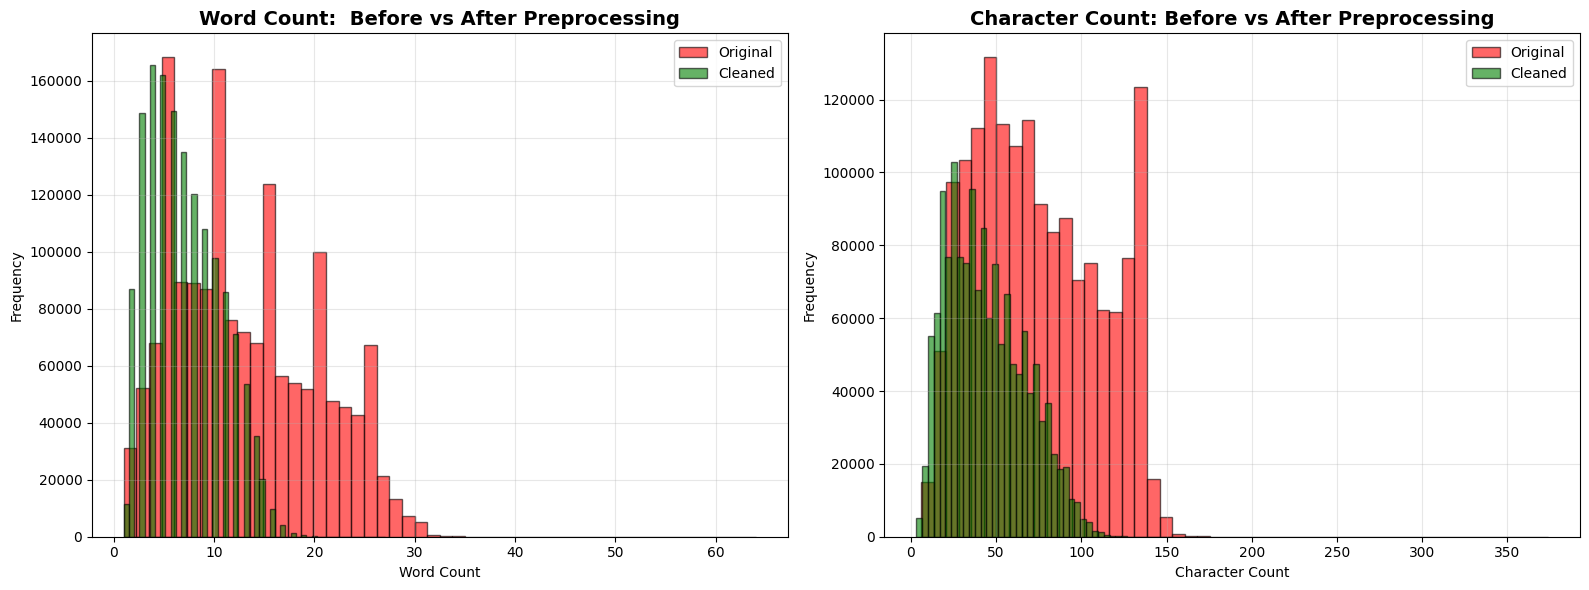

 Saved:  preprocessing_comparison.png


In [12]:
"""
VALIDATION & QUALITY CHECK
Verify the preprocessing quality
"""

print("="*80)
print("PREPROCESSING VALIDATION")
print("="*80)


# Check 1: No empty texts


print(f"\n✓ CHECK 1: Empty Texts")
empty_texts = (df['text_cleaned'].str. strip() == '').sum()
if empty_texts == 0:
    print(f"    PASS: No empty texts found")
else:
    print(f"    FAIL: {empty_texts} empty texts found")

# Check 2: No URLs remaining


print(f"\n✓ CHECK 2: URLs Removed")
urls_remaining = df['text_cleaned'].str.contains(r'http|www', case=False, regex=True).sum()
if urls_remaining == 0:
    print(f"    PASS: No URLs remaining")
else:
    print(f"    WARNING: {urls_remaining} texts still contain URLs")


# Check 3: No mentions remaining


print(f"\n✓ CHECK 3: Mentions Removed")
mentions_remaining = df['text_cleaned'].str.contains(r'@', regex=False).sum()
if mentions_remaining == 0:
    print(f"    PASS: No mentions remaining")
else:
    print(f"    WARNING:  {mentions_remaining} texts still contain @")


# Check 4: No hashtags remaining


print(f"\n✓ CHECK 4: Hashtags Removed")
hashtags_remaining = df['text_cleaned'].str.contains(r'#', regex=False).sum()
if hashtags_remaining == 0:
    print(f"    PASS: No hashtags remaining")
else:
    print(f"    WARNING: {hashtags_remaining} texts still contain #")

# Check 5: All lowercase


print(f"\n✓ CHECK 5: Lowercase Conversion")
uppercase_chars = df['text_cleaned'].str.contains(r'[A-Z]', regex=True).sum()
if uppercase_chars == 0:
    print(f"    PASS: All text is lowercase")
else:
    print(f"    WARNING: {uppercase_chars} texts contain uppercase letters")

# Check 6: No numbers remaining

print(f"\n✓ CHECK 6: Numbers Removed")
numbers_remaining = df['text_cleaned'].str.contains(r'\d', regex=True).sum()
if numbers_remaining == 0:
    print(f"    PASS: No numbers remaining")
else:
    print(f"    WARNING: {numbers_remaining} texts still contain numbers")

# Check 7: No special characters

print(f"\n✓ CHECK 7: Special Characters Removed")
special_chars = df['text_cleaned'].str. contains(r'[^a-z\s]', regex=True).sum()
if special_chars == 0:
    print(f"    PASS: No special characters remaining")
else:
    print(f"    WARNING: {special_chars} texts contain special characters")


# Check 8: Reasonable text length

print(f"\n✓ CHECK 8: Text Length")
avg_length = df['cleaned_word_count'].mean()
if 3 <= avg_length <= 50:
    print(f"    PASS: Average length is reasonable ({avg_length:.1f} words)")
else:
    print(f"    WARNING: Average length is {avg_length:.1f} words")


# Check 9: No duplicates


print(f"\n✓ CHECK 9: Duplicates")
duplicates = df['text_cleaned'].duplicated().sum()
if duplicates == 0:
    print(f"     PASS: No duplicate texts")
else:
    print(f"     WARNING: {duplicates} duplicate texts found")
# Check 10: Sentiment labels valid

print(f"\n✓ CHECK 10: Sentiment Labels")
valid_sentiments = df['sentiment'].isin(['Positive', 'Negative', 'Neutral']).all()
if valid_sentiments: 
    print(f"   PASS: All sentiment labels are valid")
else:
    invalid_count = (~df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])).sum()
    print(f"    FAIL: {invalid_count} invalid sentiment labels")

# Overall Quality Score


checks_passed = sum([
    empty_texts == 0,
    urls_remaining == 0,
    mentions_remaining == 0,
    hashtags_remaining == 0,
    uppercase_chars == 0,
    numbers_remaining == 0,
    special_chars == 0,
    3 <= avg_length <= 50,
    duplicates == 0,
    valid_sentiments
])

quality_score = (checks_passed / 10) * 100

print(f"\n{'='*80}")
print(f"OVERALL QUALITY SCORE: {quality_score:.0f}/100")
print(f"{'='*80}")

if quality_score == 100:
    print(f"EXCELLENT: All validation checks passed!")
elif quality_score >= 80:
    print(f"GOOD: Most validation checks passed")
elif quality_score >= 60:
    print(f"ACCEPTABLE: Some issues detected")
else:
    print(f"POOR:  Multiple issues detected, review preprocessing")

# Visualize before/after

print(f"\ Creating before/after visualization...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Word count comparison
axes[0].hist(df_original['text']. str.split().str.len(), bins=50, alpha=0.6, label='Original', color='red', edgecolor='black')
axes[0].hist(df['cleaned_word_count'], bins=50, alpha=0.6, label='Cleaned', color='green', edgecolor='black')
axes[0].set_title('Word Count:  Before vs After Preprocessing', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Character count comparison
axes[1].hist(df_original['text'].str.len(), bins=50, alpha=0.6, label='Original', color='red', edgecolor='black')
axes[1].hist(df['cleaned_length'], bins=50, alpha=0.6, label='Cleaned', color='green', edgecolor='black')
axes[1].set_title('Character Count: Before vs After Preprocessing', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Character Count')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('preprocessing_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Saved:  preprocessing_comparison.png")

In [13]:
df[df['text_cleaned'].str.contains(r'http|www', case=False, regex=True)]

,target,ids,date,flag,user,text,sentiment,text_cleaned,original_length,cleaned_length,original_word_count,cleaned_word_count
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Thi...",Negative,awww thats bummer shoulda got david carr third day,115,50,19,9
43,0,1467818900,Mon Apr 06 22:21:53 PDT 2009,NO_QUERY,DdubsShellBell,@JonathanRKnight Awww I soo wish I was there to see you finally comfortable! Im sad that I misse...,Negative,awww soo wish see finally comfortable sad missed,101,48,19,8
131,0,1467842377,Mon Apr 06 22:28:04 PDT 2009,NO_QUERY,bnr0201,I'm missing you babe.. but as long as your alive I'm happy.. Yawwwnn.. I'm tired my love imma t...,Negative,missing babe long alive happy yawwwnn tired love imma try sleep hopefully headstart,137,83,26,13
217,0,1467871545,Mon Apr 06 22:35:40 PDT 2009,NO_QUERY,Cherye101,"@PaulaAbdul awww, Good luck Paula!! Please don't work too hard but I hope you have fun Your ne...",Negative,awww good luck paula please dont work hard hope fun new album gonna amazing xxx,129,79,24,15
700,0,1467988885,Mon Apr 06 23:08:27 PDT 2009,NO_QUERY,Linda8286,@McCainBlogette Awwwww and you were trying to go to sleep 3 hours ago,Negative,awwwww trying sleep hours ago,70,29,13,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1465487,4,2193279518,Tue Jun 16 08:14:30 PDT 2009,NO_QUERY,xxcupcakexo,@faie awww it's my pleasure,Positive,awww pleasure,28,13,5,2
1465628,4,2193318725,Tue Jun 16 08:17:42 PDT 2009,NO_QUERY,lex_nikolas,@lindseymshaw awwww i love you and miss my best friend in the whole world world =( that comment ...,Positive,awwww love miss best friend whole world world comment meant shed tears shhh,131,75,25,13
1465765,4,2193345635,Tue Jun 16 08:19:57 PDT 2009,NO_QUERY,SocialAddiction,I have another edit to do Friday. Will post Monday! Yall u will love this guy..super star r&amp;...,Positive,another edit friday post monday yall love guysuper star rampb heartthrob saaaang owwwee,142,87,24,13
1465845,4,2193373014,Tue Jun 16 08:22:10 PDT 2009,NO_QUERY,samnooshka,@JulieNoob awww good luck Julie! looking forward to seeing him,Positive,awww good luck julie looking forward seeing,63,43,10,7


This number 10136 indicates that some URLs remain after preprocessing, and this is not a URL, but if we look at the dataset, we will find that some texts contain "awww", and in fact, "awww" does not represent a URL.

In [14]:

# Prepare final dataset

# Select columns to keep
columns_to_keep = ['sentiment', 'text', 'text_cleaned']

# Add original columns if they exist
if 'user' in df.columns:
    columns_to_keep.append('user')
if 'date' in df.columns:
    columns_to_keep.append('date')

# Create final dataset
df_final = df[columns_to_keep]. copy()

# Rename for clarity
df_final = df_final.rename(columns={'text':  'text_original', 'text_cleaned': 'text'})

print(f"\n Final Dataset Structure:")
print(f"   Shape: {df_final.shape}")
print(f"   Columns: {df_final.columns. tolist()}")

display(df_final.head())

# Save to CSV

print(f"\n Saving preprocessed dataset...")

# Main processed file
df_final.to_csv('data_preprocessed.csv', index=False)
print(f"    Saved:  data_preprocessed.csv ({len(df_final):,} rows)")

# Save compact version (only necessary columns for training)
df_compact = df_final[['sentiment', 'text']].copy()
df_compact.to_csv('data_training_ready.csv', index=False)
print(f"    Saved: data_training_ready.csv ({len(df_compact):,} rows)")


 Final Dataset Structure:
   Shape: (1466544, 5)
   Columns: ['sentiment', 'text_original', 'text', 'user', 'date']


,sentiment,text_original,text,user,date
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Thi...",awww thats bummer shoulda got david carr third day,_TheSpecialOne_,Mon Apr 06 22:19:45 PDT 2009
1,Negative,is upset that he can't update his Facebook by texting it... and might cry as a result School to...,upset cant update facebook texting might cry result school today also blah,scotthamilton,Mon Apr 06 22:19:49 PDT 2009
2,Negative,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived many times ball managed save rest bounds,mattycus,Mon Apr 06 22:19:53 PDT 2009
3,Negative,my whole body feels itchy and like its on fire,whole body feels itchy like fire,ElleCTF,Mon Apr 06 22:19:57 PDT 2009
4,Negative,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you a...",behaving mad cant see,Karoli,Mon Apr 06 22:19:57 PDT 2009



 Saving preprocessed dataset...
    Saved:  data_preprocessed.csv (1,466,544 rows)
    Saved: data_training_ready.csv (1,466,544 rows)


In [15]:
# Save preprocessing statistics
preprocessing_stats = {
    'original_count': len(df_original),
    'final_count': len(df_final),
    'removed_count': len(df_original) - len(df_final),
    'retention_rate': len(df_final) / len(df_original) * 100,
    'sentiment_distribution': df_final['sentiment'].value_counts().to_dict(),
    'avg_original_length': df_original['text'].str.len().mean(),
    'avg_cleaned_length': df_final['text'].str.len().mean(),
    'avg_original_words': df_original['text'].str.split().str.len().mean(),
    'avg_cleaned_words': df_final['text'].str.split().str.len().mean(),
    'quality_score': quality_score
}

import json
with open('preprocessing_stats.json', 'w') as f:
    json.dump(preprocessing_stats, f, indent=2)

print(f"    Saved: preprocessing_stats.json")

    Saved: preprocessing_stats.json
